In [6]:
from PIL import Image
from torchvision import transforms, datasets

import numpy as np
from matplotlib import pyplot as plt

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
# norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # For IMAGENET1K

# From here: https://github.com/kuangliu/pytorch-cifar/issues/19#issue-268972488
norm = Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  # For CIFAR-10

# For IMAGENET1K
# model = resnet50(weights="IMAGENET1K_V2")


# For cifar-10
# https://github.com/chenyaofo/pytorch-cifar-models?ysclid=ltetspeamk505700051
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)


# Model to eval
model.eval();

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:0


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


### Маскировка части изображения

In [8]:
# DEPRECATED
def mask_part(image: torch.Tensor, ind: int, count_classes: int) -> torch.Tensor:
    _, c, h, w = image.shape
    bbox_x1 = ind * (h // count_classes)
    bbox_x2 = (ind + 1) * (h // count_classes)

    bbox_y1 = ind * (w // count_classes)
    bbox_y2 = (ind + 1) * (w // count_classes)

    ans = image.clone().detach()
    ans[:, :, bbox_x1: bbox_x2, bbox_y1: bbox_y2] = torch.zeros([1, 3, h // count_classes, w // count_classes])

    return ans

In [56]:
import math

class MaskImage(nn.Module): # Закрывает квадраты на диагонали картинки
    def __init__(self, class_ind, count_classes):
        super(MaskImage, self).__init__()
        self.class_ind = class_ind
        self.count_classes = count_classes
    def forward(self, image):
        c, h, w = image.shape
        bbox_x1 = self.class_ind * (h // self.count_classes)
        bbox_x2 = (self.class_ind + 1) * (h // self.count_classes)

        bbox_y1 = self.class_ind * (w // self.count_classes)
        bbox_y2 = (self.class_ind + 1) * (w // self.count_classes)

        mask = torch.ones_like(image)  # maybe add requires_grad = Ture
        mask[:, bbox_x1: bbox_x2, bbox_y1: bbox_y2] = torch.zeros([3, h // self.count_classes, w // self.count_classes])

        return image * mask


class MaskImageAll(nn.Module):
    def __init__(self, class_ind, count_classes):
        super(MaskImageAll, self).__init__()
        self.class_ind = class_ind
        self.count_classes = count_classes

    def forward(self, image):
        c, h, w = image.shape

        num_columns = int(math.ceil(math.sqrt(self.count_classes)))
        num_rows = int(math.ceil(self.count_classes / float(num_columns)))

        tile_w, tile_h = int(math.floor(w / num_columns)), int(math.floor(h / num_rows))


        row = self.class_ind // num_columns
        column = self.class_ind % num_columns

        mask = torch.ones_like(image)  # maybe add requires_grad = Ture
        mask[:, row * tile_h: (row + 1) * tile_h, column * tile_w: (column + 1) * tile_w] = torch.zeros([3, tile_h, tile_w])

        return image * mask


In [40]:
trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### Проверка на работоспособность

Text(0.5, 1.0, 'With hidden on diag')

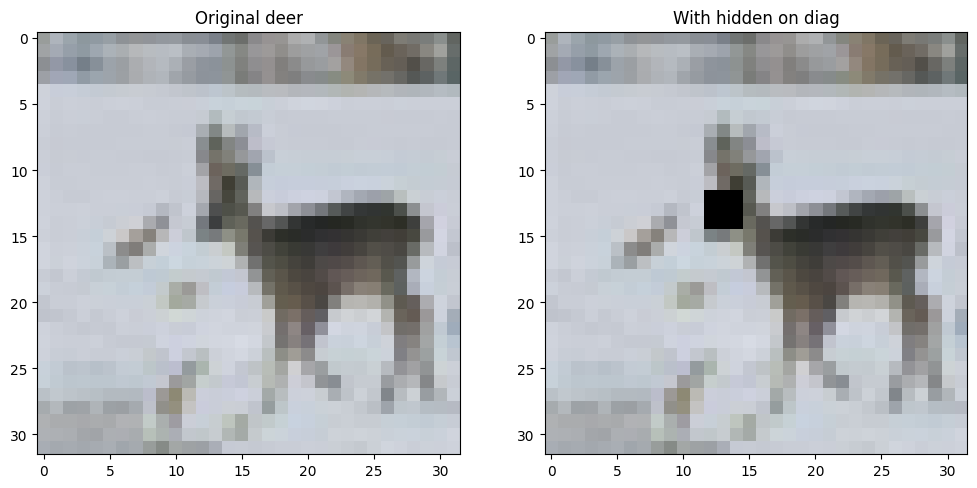

In [45]:
index = 20
test_image = trainset[index][0]
label = trainset[index][1]
f, axs = plt.subplots(1,2, figsize=(12, 8))
axs[0].imshow(test_image.permute(1, 2, 0))
axs[0].set_title(f"Original {classes[label]}")
# axs[1].imshow(mask_part(test_image.unsqueeze(0), label, 10).squeeze().permute(1, 2, 0))
axs[1].imshow(MaskImage(label, 10)(test_image).permute(1, 2, 0))
axs[1].set_title(f"With hidden on diag")


3 4 10 8


Text(0.5, 1.0, 'With hidden (divided full image)')

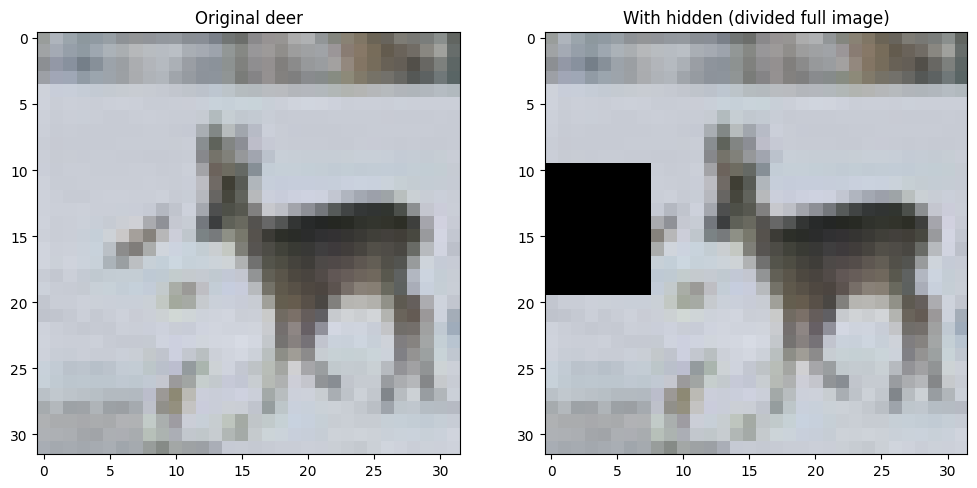

In [46]:
index = 20
test_image = trainset[index][0]
label = trainset[index][1]
f, axs = plt.subplots(1,2, figsize=(12, 8))
axs[0].imshow(test_image.permute(1, 2, 0))
axs[0].set_title(f"Original {classes[label]}")
# axs[1].imshow(mask_part(test_image.unsqueeze(0), label, 10).squeeze().permute(1, 2, 0))
axs[1].imshow(MaskImageAll(label, 10)(test_image).permute(1, 2, 0))
axs[1].set_title(f"With hidden (divided full image)")


### Собственно, само обучение

In [49]:
def train(model, univ_image, epochs, batch_size, num_classes, mask) -> torch.Tensor:
    opt = optim.SGD([univ_image], lr=1e-1)
    criterion = nn.CrossEntropyLoss()
    cur_class = 0
    for t in range(epochs):

        batch = []
        labels = []
        for k in range(batch_size):
            batch.append(mask(cur_class, num_classes)(univ_image))
            labels.append(cur_class)
            cur_class = (cur_class + 1) % num_classes
        batch = torch.stack(batch, dim=0).to(device)
        labels = torch.LongTensor(labels).to(device)

        preds = model(norm(batch))
        loss = criterion(preds, labels)

        if t % (epochs // 20) == 0:
            # print(preds.shape, labels.shape)
            print(f"EPOCH = {t}, loss = {loss.item()}")

        opt.zero_grad()
        loss.backward()
        opt.step()

        univ_image.data.clamp_(0, 1)
    return univ_image

Попробуем с маской на диагонали

In [62]:
univ_image = torch.zeros((3, 32, 32), requires_grad=True, device=device)
univ_image = train(model, univ_image, 2000, 1, 10, MaskImage)

EPOCH = 0, loss = 1.409917950630188
EPOCH = 100, loss = 5.304121971130371
EPOCH = 200, loss = 5.047021865844727
EPOCH = 300, loss = 5.108925819396973
EPOCH = 400, loss = 5.197288513183594
EPOCH = 500, loss = 5.015269756317139
EPOCH = 600, loss = 5.438301086425781
EPOCH = 700, loss = 5.651182174682617
EPOCH = 800, loss = 5.646694660186768
EPOCH = 900, loss = 5.762123107910156
EPOCH = 1000, loss = 5.651244163513184
EPOCH = 1100, loss = 5.655427932739258
EPOCH = 1200, loss = 5.283720016479492
EPOCH = 1300, loss = 4.962106704711914
EPOCH = 1400, loss = 3.392937421798706
EPOCH = 1500, loss = 0.757061243057251
EPOCH = 1600, loss = 0.048681121319532394
EPOCH = 1700, loss = 0.03725603595376015
EPOCH = 1800, loss = 0.02957254648208618
EPOCH = 1900, loss = 0.025820894166827202


### Старое

In [ ]:
import torch.optim as optim

# For CIFAR-10: (3, 32, 32)
univ_image = torch.zeros((3, 32, 32), requires_grad=True, device=device)
opt = optim.SGD([univ_image], lr=1e-1)
criterion = nn.CrossEntropyLoss()

batch_size = 1  # From 1 to number of classes
epochs = 2000

In [ ]:
cur_class = 0
for t in range(epochs):

    batch = []
    labels = []
    for k in range(batch_size):
        batch.append(MaskImage(cur_class, 10)(univ_image))
        labels.append(cur_class)
        cur_class = (cur_class + 1) % 10
    batch = torch.stack(batch, dim=0).to(device)
    labels = torch.LongTensor(labels).to(device)

    preds = model(norm(batch))
    loss = criterion(preds, labels)

    if t % (epochs // 20) == 0:
        # print(preds.shape, labels.shape)
        print(f"EPOCH = {t}, loss = {loss.item()}")

    opt.zero_grad()
    loss.backward()
    opt.step()

    univ_image.data.clamp_(0, 1)

EPOCH = 0, loss = 1.409917950630188
EPOCH = 100, loss = 5.409339904785156
EPOCH = 200, loss = 5.037313461303711
EPOCH = 300, loss = 5.250380039215088
EPOCH = 400, loss = 5.011770725250244
EPOCH = 500, loss = 5.163639545440674
EPOCH = 600, loss = 5.018764972686768
EPOCH = 700, loss = 5.272881507873535
EPOCH = 800, loss = 5.444141864776611
EPOCH = 900, loss = 5.727757930755615
EPOCH = 1000, loss = 5.074760913848877
EPOCH = 1100, loss = 3.1475398540496826
EPOCH = 1200, loss = 2.390522003173828
EPOCH = 1300, loss = 7.1358137130737305
EPOCH = 1400, loss = 0.7928241491317749
EPOCH = 1500, loss = 0.0649295374751091
EPOCH = 1600, loss = 0.0432342067360878
EPOCH = 1700, loss = 0.03561486676335335
EPOCH = 1800, loss = 0.03165870159864426
EPOCH = 1900, loss = 0.02816583402454853


### Проверка результатов

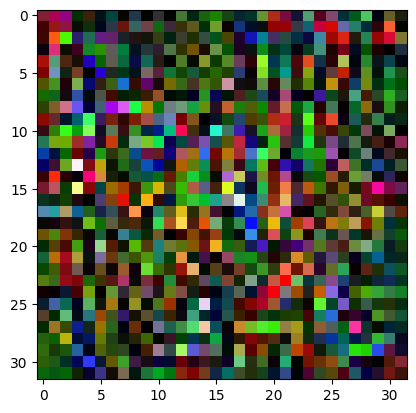

In [63]:
# Получилось вот такое изображение
plt.imshow((univ_image.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8))

In [64]:
def check_image(model, u_image, classes, mask):
    plt.rcParams['text.usetex'] = False
    u_image = u_image.detach()
    f, axs = plt.subplots(2, 5, figsize=(16, 11), tight_layout=True)
    for class_ind in range(len(classes)):
        masked_image = mask(class_ind, len(classes))(u_image)

        axs[class_ind % 2, class_ind // 2].imshow((masked_image.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8))

        exp_label = classes[class_ind]
        pred_label = model(norm(masked_image.unsqueeze(0))).squeeze().detach().cpu().argmax()
        pred_label = classes[pred_label]

        ax_title = "exp_label={}, pred_label={}".format(exp_label, pred_label)
        if pred_label != exp_label:
            axs[class_ind % 2, class_ind // 2].set_title(ax_title, color='r')
        else:
            axs[class_ind % 2, class_ind // 2].set_title(ax_title)
    u_image.to(device)

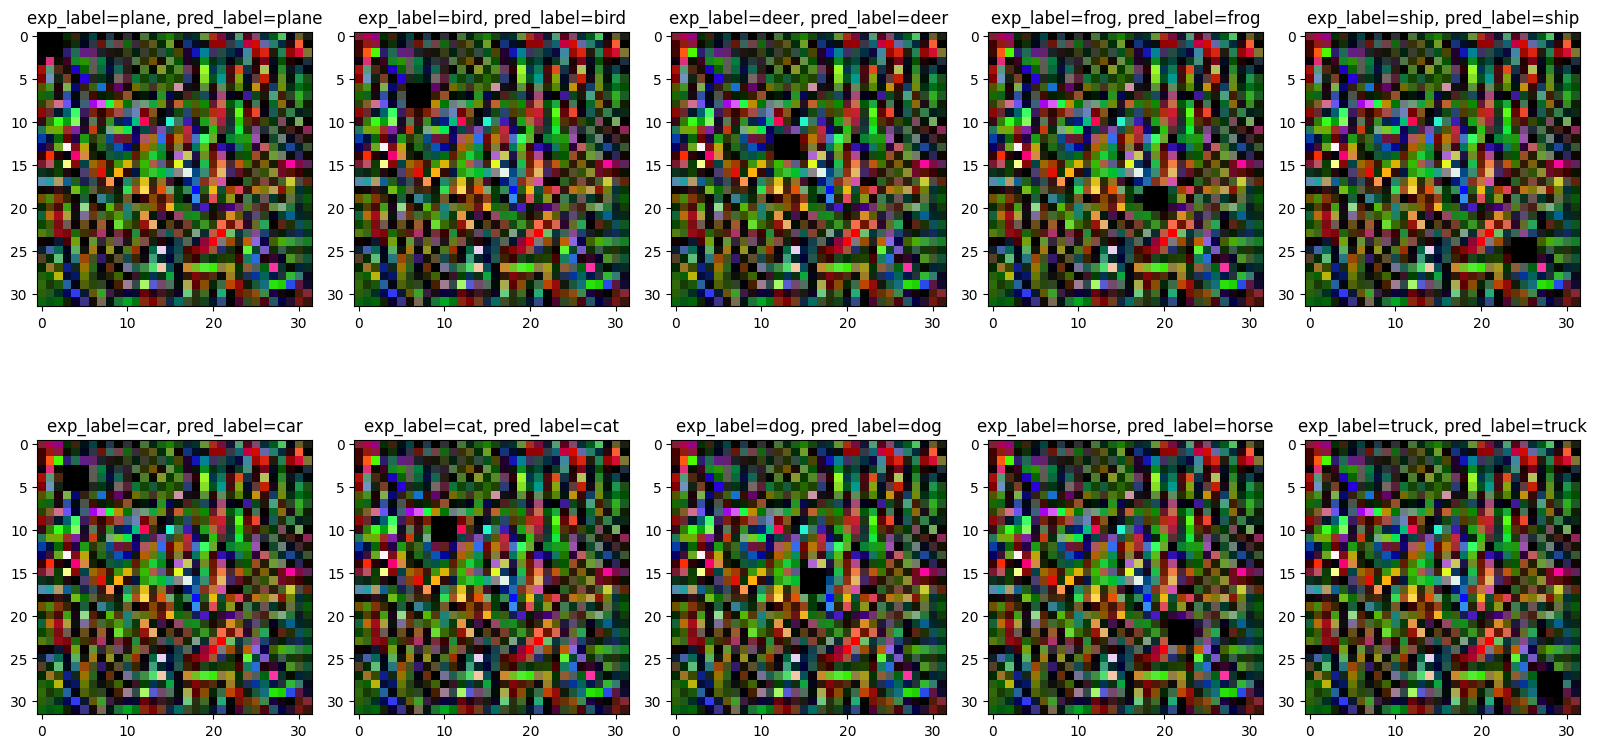

In [65]:
check_image(model, univ_image, classes, MaskImage)

### Получилось!!!

А теперь попробуем с маской, покрывающей не по диагонали, а по всей картинке

In [66]:
univ_image = torch.zeros((3, 32, 32), requires_grad=True, device=device)
univ_image = train(model, univ_image, 2000, 1, 10, MaskImageAll)

EPOCH = 0, loss = 1.409917950630188
EPOCH = 100, loss = 0.6364034414291382
EPOCH = 200, loss = 0.04414631053805351
EPOCH = 300, loss = 0.021930566057562828
EPOCH = 400, loss = 0.015671314671635628
EPOCH = 500, loss = 0.011690324172377586
EPOCH = 600, loss = 0.00910511240363121
EPOCH = 700, loss = 0.007495375815778971
EPOCH = 800, loss = 0.006358274724334478
EPOCH = 900, loss = 0.005627147853374481
EPOCH = 1000, loss = 0.004972116556018591
EPOCH = 1100, loss = 0.004509873688220978
EPOCH = 1200, loss = 0.00414251396432519
EPOCH = 1300, loss = 0.003746872302144766
EPOCH = 1400, loss = 0.0034459992311894894
EPOCH = 1500, loss = 0.0032065899576991796
EPOCH = 1600, loss = 0.003012050176039338
EPOCH = 1700, loss = 0.00285836448892951
EPOCH = 1800, loss = 0.002729383297264576
EPOCH = 1900, loss = 0.002616198966279626


### Проверка результатов

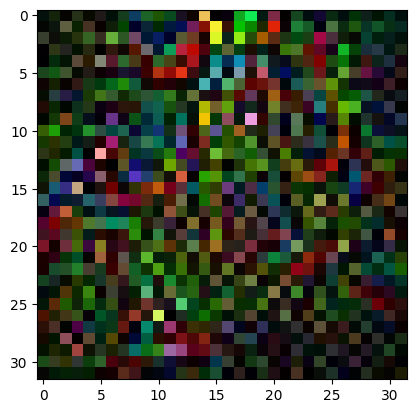

In [68]:
# Получилось вот такое изображение
plt.imshow((univ_image.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8))

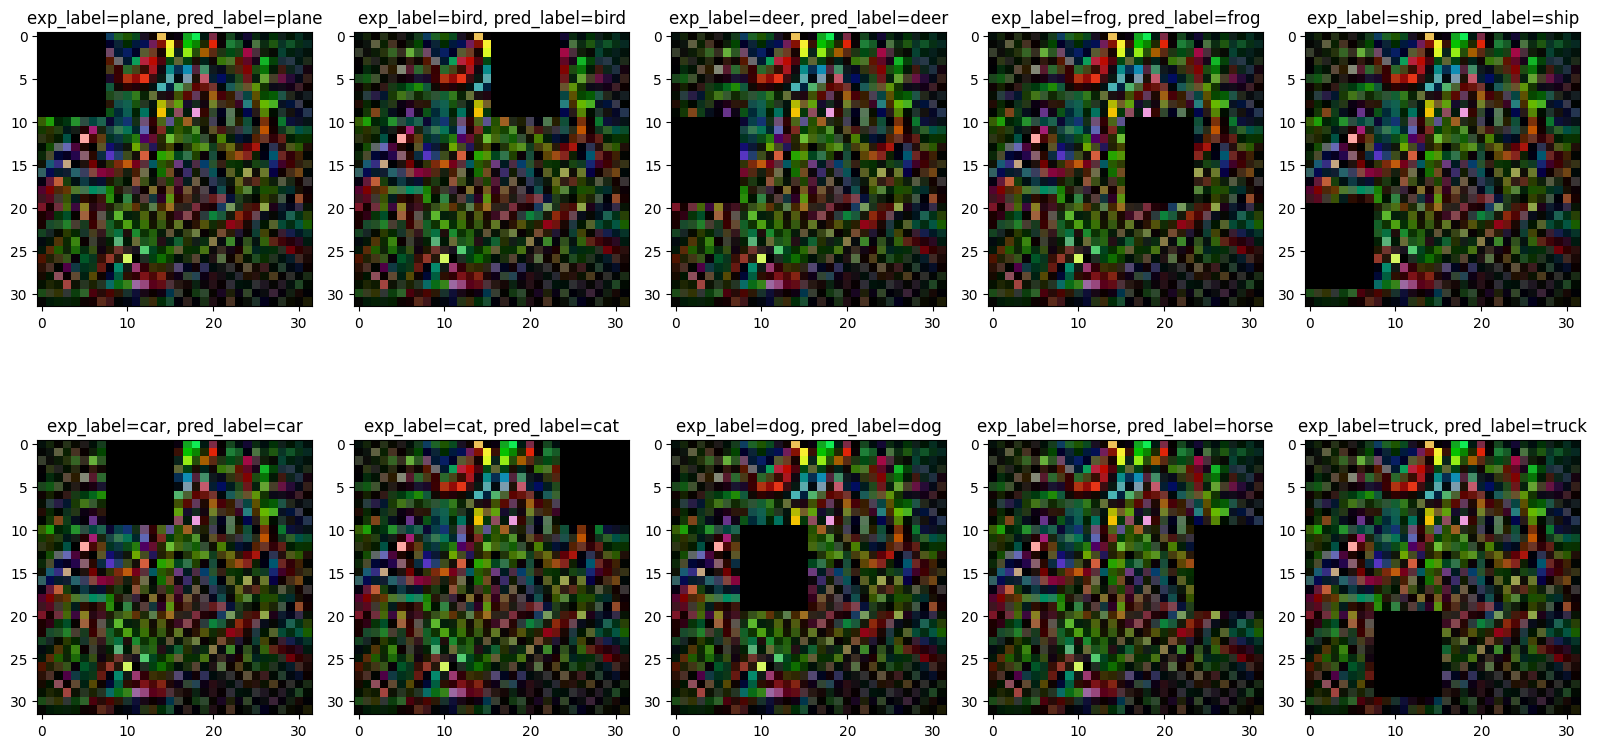

In [69]:
check_image(model, univ_image, classes, MaskImageAll)

### Выводы:

Как видно, что чем меньше мы закрываем область на картинке, тем дольше приходится подбирать картинку, обманывающую модель (ибо когда я закрыл область 3x3, то ошибка начала падать только к 1000-ой эпохе, в то время как при сокрытии области 8х10 ошибка начала падать уже после 100-ой эпохи)